In [208]:
%matplotlib inline
import pandas as pd
import numpy as np
mySpecie='Homo_sapiens'
outMergedDir='/cellar/users/btsui/all_seq_snp/'+mySpecie+'_all_merged_snp.TCGA.pickle'


In [3]:
mutation_df=pd.read_pickle(outMergedDir)

In [17]:
lgg_rest_meta_df=pd.read_pickle('../lgg_rest_meta.pickle')

In [25]:
uuid_barcode_map_df=pd.read_csv( '/cellar/users/andreabc/GDC_barcodes/uuid_barcode_map.txt',sep='\s+')

mutation_df_uuui=mutation_df.index.get_level_values('Run_digits').drop_duplicates()

uuid_to_barcode_S=uuid_barcode_map_df.set_index('file_id')['sample_barcode'].dropna()
tumor_samples=uuid_to_barcode_S.index[uuid_to_barcode_S.str.contains('01\w')]

In [26]:
#uuid_barcode_map_df.set_index('file_id')['barcode']
#uuid_barcode_map_df[uuid_barcode_map_df.file_id=='386d69e7-b4a7-4981-beb8-98f088c689f7']


,file_id,file_name,barcode,sample_barcode,disease,type,data_format
223782,386d69e7-b4a7-4981-beb8-98f088c689f7,C494.TCGA-QH-A86X-01A-11D-A36O-08.1_gdc_realn.bam,TCGA-QH-A86X,TCGA-QH-A86X-01A,TCGA-LGG,aligned_reads,BAM


AA mutation 

p.R132H (Substitution - Missense, position 132, R➞H)

CDS mutation 

c.395G>A (Substitution, position 395, G➞A)
Nucleotides inserted n/a Genomic coordinates GRCh38, 2:208248388..208248388, view Ensembl contig

In [245]:
queryChr='2'
m_chr=mutation_df.index.get_level_values('Chr')==queryChr
targetPos=208248388
window_size=0.5*(10.0**5)
m_pos_upper=mutation_df.index.get_level_values('Pos')<=(targetPos+window_size)
m_pos_lower=mutation_df.index.get_level_values('Pos')>=(targetPos-window_size)
mutation_df_sub_df=mutation_df[m_chr&m_pos_lower&m_pos_upper]

In [247]:
inVcfDir='/data/cellardata/users/btsui/dbsnp/Homo_sapiens/All_20170710.f1_byte2_not_00.vcf.gz' 
vcfDf=pd.read_csv(inVcfDir,sep='\t',header=None)
vcfDf.columns=['Chr','Pos','RsId','RefBase','AltBase','','','Annot']
vcfDf['Chr']=vcfDf['Chr'].astype(np.str)
my_chrom_vcfDf=vcfDf[(vcfDf['Chr']==queryChr)]
posToRefBase=my_chrom_vcfDf.set_index('Pos')['RefBase']
posToRefBase=posToRefBase.str[0]
posToRefBase=posToRefBase.groupby(posToRefBase.index).first()

/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [248]:
resetMutDf=mutation_df_sub_df.reset_index()

In [249]:
resetMutDf['Barcode']=uuid_to_barcode_S.loc[resetMutDf['Run_digits']].values


resetMutDf['PID']=resetMutDf['Barcode'].apply(lambda S:"-".join(S.split('-')[:-1]))#.str.split('-').apply(lambda L:'-'.join(L[:-3]))#.str.joins('-')

resetMutDf['sample_type']=resetMutDf['Barcode'].str.split('-').str[-1].str[:2]

resetMutDf['base_ref']=posToRefBase.loc[resetMutDf.Pos].values

resetMutDf['base_is_ref']=resetMutDf['base_ref']==resetMutDf['base']

In [254]:
resetMutDf.sample_type.value_counts()

10    653
01    617
02     76
12     16
Name: sample_type, dtype: int64

In [255]:
#tumorSubDf

In [256]:
tumorSubDf=resetMutDf[resetMutDf.sample_type.isin(['01','10'])]
pidVc=tumorSubDf.drop_duplicates(['PID','sample_type']).groupby('PID').size()
patients_with_normal_and_tumor=pidVc.index[pidVc>=2]
continDfs=tumorSubDf[tumorSubDf.PID.isin(patients_with_normal_and_tumor)
          ].groupby(['PID','Chr','Pos','base_is_ref','sample_type'])['ReadDepth'].sum().unstack().fillna(0)

In [257]:
from scipy import stats


myDict={}
g_list=['PID','Chr','Pos']
for g,subDf in continDfs.groupby(g_list):
    #reference allele only 
    if subDf.shape[0]==2:
        stat,p=stats.fisher_exact(subDf)
        myDict[g]=p
    else:
        myDict[g]=1
    

exactFisherNameS=pd.Series(myDict)
exactFisherNameS.index.names=g_list

In [260]:
#mahattan 
resetDf=(-np.log10(exactFisherNameS)).reset_index(name='neg_10_p')

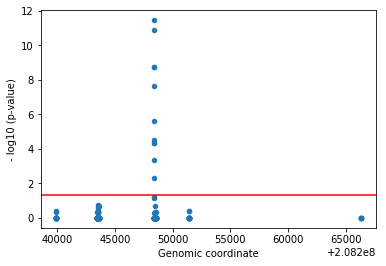

In [268]:
ax=resetDf.plot.scatter(x='Pos',y='neg_10_p')
ax.set_ylabel('- log10 (p-value)')
ax.set_xlabel('Genomic coordinate')
ax.axhline(-np.log10(0.05),color='red')

In [262]:

unstackDf=resetMutDf.set_index(['Barcode','Chr','Pos','base','sample_type','ref_base'])['ReadDepth'].unstack()

KeyError: 'ref_base'

In [109]:
unstackDf

sample_type                            01A  02A  02B    10A  10B  10D  12A
Barcode          Chr Pos       base                                       
TCGA-DB-A4X9-01A 2   208248388 C      38.0  NaN  NaN    NaN  NaN  NaN  NaN
                               T      14.0  NaN  NaN    NaN  NaN  NaN  NaN
                     208248389 G      53.0  NaN  NaN    NaN  NaN  NaN  NaN
                     208248468 G      37.0  NaN  NaN    NaN  NaN  NaN  NaN
                     208248572 C      50.0  NaN  NaN    NaN  NaN  NaN  NaN
TCGA-DB-A4XA-01A 2   208248388 C      55.0  NaN  NaN    NaN  NaN  NaN  NaN
                               T      12.0  NaN  NaN    NaN  NaN  NaN  NaN
                     208248389 G      73.0  NaN  NaN    NaN  NaN  NaN  NaN
                     208248468 G      93.0  NaN  NaN    NaN  NaN  NaN  NaN
                     208248572 C      75.0  NaN  NaN    NaN  NaN  NaN  NaN
TCGA-DB-A4XB-01A 2   208248388 C      41.0  NaN  NaN    NaN  NaN  NaN  NaN
                               T       8.0  NaN  NaN    NaN  NaN  NaN  NaN
                     208248389 G      50.0  NaN  NaN    NaN  NaN  NaN  NaN
                     208248468 G      65.0  NaN  NaN    NaN  NaN  NaN  NaN
                     208248572 C      74.0  NaN  NaN    NaN  NaN  NaN  NaN
TCGA-DB-A4XB-10A 2   208248388 A       NaN  NaN  NaN    1.0  NaN  NaN  NaN
                               C       NaN  NaN  NaN   64.0  NaN  NaN  NaN
                     208248389 G       NaN  NaN  NaN   65.0  NaN  NaN  NaN
                     208248468 G       NaN  NaN  NaN   78.0  NaN  NaN  NaN
                     208248572 C       NaN  NaN  NaN   83.0  NaN  NaN  NaN
TCGA-DB-A4XC-01A 2   208248388 C      35.0  NaN  NaN    NaN  NaN  NaN  NaN
                               T       3.0  NaN  NaN    NaN  NaN  NaN  NaN
                     208248389 G      40.0  NaN  NaN    NaN  NaN  NaN  NaN
                     208248468 G      56.0  NaN  NaN    NaN  NaN  NaN  NaN
                     208248572 C      51.0  NaN  NaN    NaN  NaN  NaN  NaN
TCGA-DB-A4XC-10A 2   208248388 C       NaN  NaN  NaN   55.0  NaN  NaN  NaN
                     208248389 G       NaN  NaN  NaN   59.0  NaN  NaN  NaN
                     208248468 G       NaN  NaN  NaN   67.0  NaN  NaN  NaN
                     208248572 C       NaN  NaN  NaN   63.0  NaN  NaN  NaN
TCGA-DB-A64L-10A 2   208248388 C       NaN  NaN  NaN   67.0  NaN  NaN  NaN
...                                    ...  ...  ...    ...  ...  ...  ...
TCGA-VM-A8CA-01A 2   208248388 C      90.0  NaN  NaN    NaN  NaN  NaN  NaN
                               T      29.0  NaN  NaN    NaN  NaN  NaN  NaN
                     208248389 G     125.0  NaN  NaN    NaN  NaN  NaN  NaN
                     208248468 G     175.0  NaN  NaN    NaN  NaN  NaN  NaN
                               T       1.0  NaN  NaN    NaN  NaN  NaN  NaN
                     208248572 C     169.0  NaN  NaN    NaN  NaN  NaN  NaN
TCGA-VM-A8CA-10A 2   208248388 C       NaN  NaN  NaN  128.0  NaN  NaN  NaN
                               T       NaN  NaN  NaN    1.0  NaN  NaN  NaN
                     208248389 G       NaN  NaN  NaN  131.0  NaN  NaN  NaN
                     208248468 G       NaN  NaN  NaN  144.0  NaN  NaN  NaN
                     208248572 C       NaN  NaN  NaN  170.0  NaN  NaN  NaN
TCGA-VM-A8CH-01A 2   208248388 C     125.0  NaN  NaN    NaN  NaN  NaN  NaN
                     208248389 A      35.0  NaN  NaN    NaN  NaN  NaN  NaN
                               G      89.0  NaN  NaN    NaN  NaN  NaN  NaN
                     208248468 C       1.0  NaN  NaN    NaN  NaN  NaN  NaN
                               G     164.0  NaN  NaN    NaN  NaN  NaN  NaN
                     208248572 C     159.0  NaN  NaN    NaN  NaN  NaN  NaN
TCGA-VM-A8CH-10A 2   208248388 C       NaN  NaN  NaN  118.0  NaN  NaN  NaN
                     208248389 G       NaN  NaN  NaN  123.0  NaN  NaN  NaN
                     208248468 G       NaN  NaN  NaN  163.0  NaN  NaN  NaN
                     2082

In [90]:
resetMutDf['is_tumor']=resetMutDf.Run_digits.isin(tumor_samples)

In [91]:
resetMutDf

features,Run_db,Run_digits,Chr,Pos,base,ReadDepth,AverageBaseQuality,is_tumor
0,TCGA,386d69e7-b4a7-4981-beb8-98f088c689f7,2,208248388,C,74,29,True
1,TCGA,386d69e7-b4a7-4981-beb8-98f088c689f7,2,208248388,T,31,31,True
2,TCGA,386d69e7-b4a7-4981-beb8-98f088c689f7,2,208248389,A,1,9,True
3,TCGA,386d69e7-b4a7-4981-beb8-98f088c689f7,2,208248389,G,107,30,True
4,TCGA,386d69e7-b4a7-4981-beb8-98f088c689f7,2,208248468,G,116,32,True
5,TCGA,386d69e7-b4a7-4981-beb8-98f088c689f7,2,208248572,C,107,31,True
6,TCGA,4c5b9eb6-fb8b-4c7b-976e-c6d6de12a220,2,208248388,C,84,29,False
7,TCGA,4c5b9eb6-fb8b-4c7b-976e-c6d6de12a220,2,208248389,G,88,29,False
8,TCGA,4c5b9eb6-fb8b-4c7b-976e-c6d6de12a220,2,208248468,G,93,32,False
9,TCGA,4c5b9eb6-fb8b-4c7b-976e-c6d6de12a220,2,208248572,C,91,30,False


In [73]:

mutation_df_sub_df[run_i.isin(tumor_samples)].groupby(['Chr','Pos','base'])['ReadDepth'].mean()

Chr  Pos        base
2    208248388  A         1.000000
                C        73.585366
                G         1.333333
                T        21.575758
     208248389  A        14.750000
                C         1.000000
                G        92.609756
                T         1.000000
     208248468  A        20.833333
                C         1.000000
                G       105.804878
                T         1.000000
     208248572  A         1.000000
                C       107.975610
                G         1.000000
                T         1.000000
Name: ReadDepth, dtype: float64

In [74]:
mutation_df_sub_df[~run_i.isin(tumor_samples)].groupby(['Chr','Pos','base'])['ReadDepth'].mean()

Chr  Pos        base
2    208248388  A         1.000000
                C        96.509804
                G         1.000000
                T         6.600000
     208248389  A         1.200000
                C        10.000000
                G        98.588235
                T         1.000000
     208248468  A        19.000000
                C         1.000000
                G       113.960784
                T         1.000000
     208248572  A         1.000000
                C       116.196078
                G         1.000000
                T         1.000000
Name: ReadDepth, dtype: float64

In [85]:

mutation_df_sub_df['base_ref']

features                                                        ReadDepth  \
Run_db Run_digits                           Chr Pos       base              
TCGA   386d69e7-b4a7-4981-beb8-98f088c689f7 2   208248388 C            74   
                                                          T            31   
                                                208248389 A             1   
                                                          G           107   
                                                208248468 G           116   
                                                208248572 C           107   
       4c5b9eb6-fb8b-4c7b-976e-c6d6de12a220 2   208248388 C            84   
                                                208248389 G            88   
                                                208248468 G            93   
                                                208248572 C            91   
       80ec445a-227e-4fdf-9591-f45cc32435f3 2   208248388 C            74   
                                                208248389 G            78   
                                                208248468 G            95   
                                                208248572 C            98   
       84943493-e5ef-4099-8706-09afa625b076 2   208248388 C            38   
                                                          T            14   
                                                208248389 G            53   
                                                208248468 G            37   
                                                208248572 C            50   
       8b629c28-5b46-48ec-a4e3-0d0a458860fb 2   208248388 C           118   
                                                208248389 G           121   
                                                208248468 G           118   
                                                208248572 C           111   
       97fead0d-0065-43a8-909f-9436f7dee4cf 2   208248388 A             1   
                                                          C           119   
                                                208248389 G           119   
                                                208248468 A            39   
                                                          G           112   
                                                208248572 C           105   
       c65e92e8-0334-462d-ae4d-1da5e106414b 2   208248388 C           118   
...                                                                   ...   
       51da3bb2-6045-4f15-a7da-0dec84dda0ed 2   208248389 G            88   
                                                208248468 G            97   
                                                208248572 C            88   
       57dcc1f9-31ce-4466-92d6-2938ee88139b 2   208248388 C           109   
                                                          T            13   
                                                208248389 G           125   
                                                208248468 G           188   
                                                208248572 C           155   
                                                          G             1   
       71cf2de6-94e0-4812-858a-61fe6f93c7b9 2   208248388 C            83   
                                                          T            17   
                                                208248389 G           105   
                                                208248468 G           123   
                                                208248572 C           128   
       8e71142f-7d5c-4f53-b622-9fc7ce3c588d 2   208248388 A             1   
                                                          C            64   
                                                208248389 G            65   
                                                208248468 G            78   
                                                208248572 C            83

In [20]:
lgg_rest_meta_df['submitter_id'].values

array(['TCGA-DU-5870-01A-11D-1705-08_TCGA-DU-5870-10A-01D-1705-08_varscan_dr_10.0',
       'TCGA-DB-5279-01A-01D-1468-08_TCGA-DB-5279-10A-01D-1468-08_somaticsniper',
       'TCGA-DU-A76K-01A-11D-A33T-08_TCGA-DU-A76K-10A-01D-A33W-08_mutect',
       ...,
       'TCGA-HT-8110-01A-11D-2395-08_TCGA-HT-8110-10A-01D-2396-08_mutect',
       'TCGA-RY-A845-01A-11D-A36O-08_TCGA-RY-A845-10A-01D-A367-08_varscan_dr_10.0',
       'TCGA-DU-7018-01A-11D-2024-08_TCGA-DU-7018-10A-01D-2024-08_varscan_dr_10.0'],
      dtype=object)

In [9]:
mutation_df_uuui

Index(['386d69e7-b4a7-4981-beb8-98f088c689f7',
       '4c5b9eb6-fb8b-4c7b-976e-c6d6de12a220',
       '80ec445a-227e-4fdf-9591-f45cc32435f3',
       '84943493-e5ef-4099-8706-09afa625b076',
       '8b629c28-5b46-48ec-a4e3-0d0a458860fb',
       '97fead0d-0065-43a8-909f-9436f7dee4cf',
       'c65e92e8-0334-462d-ae4d-1da5e106414b',
       'e1c3f899-d482-46aa-b0d0-78ff0dccc9f9',
       'e55c8de3-3a92-42f2-bc1e-70a21355d696',
       'fd5d9171-979e-4742-adec-179f19bf6c06',
       '09e3d52c-bf91-4a09-ba9e-4f6c03ebfcb5',
       '5ec3bbd6-30af-4aa2-b0f1-97ed720748af',
       '034fd301-31a5-439d-905a-c95ba31fa017',
       '25650a4b-775b-485b-92c2-3f8f30ba4169',
       '51f74490-de42-4f09-b131-44c649a8ab73',
       '5a94e952-0d14-4002-8afc-e1be752538d9',
       '62d58c23-bfc9-4321-b356-7ebd8da30880',
       '68228bf3-3af0-4ac6-a85b-d07dd18ad344',
       'bc27f71a-4222-4940-8a64-246e2b9f3d44',
       'ea2e8432-3de3-4c8b-8e8e-4e9ec4f1d745',
       'f36d778a-2c49-43aa-a577-7a6a921ad6cc',
       'fe63a